In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
# Import dataset
df = pd.read_csv("/content/drive/MyDrive/Forex/forex.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close
0,2017-05-12,64.389999,64.394997,64.120003,64.360001,64.360001
1,2017-05-15,64.236000,64.236000,64.019997,64.165497,64.165497
2,2017-05-16,64.038300,64.142998,63.990002,64.038300,64.038300
3,2017-05-17,64.035500,64.180000,63.880001,63.900002,63.900002
4,2017-05-18,64.230003,65.139999,64.220001,64.230003,64.230003


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000
mean,71.114373,71.352559,70.886654,71.137963,71.137963
std,3.895747,3.932556,3.836541,3.889727,3.889727
min,63.264999,63.419998,63.209999,63.264999,63.264999
25%,68.748001,69.008749,68.548498,68.830002,68.830002
50%,71.786499,72.101749,71.515000,71.818748,71.818748
75%,74.287098,74.517249,74.071749,74.289022,74.289022
max,77.684998,77.754997,77.335999,77.570000,77.570000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1305 non-null   object 
 1   Open       1302 non-null   float64
 2   High       1302 non-null   float64
 3   Low        1302 non-null   float64
 4   Close      1302 non-null   float64
 5   Adj Close  1302 non-null   float64
dtypes: float64(5), object(1)
memory usage: 61.3+ KB


In [ ]:
df.dropna(inplace=True)
df.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
dtype: bool

In [ ]:
# Checking Data type of each column
print("Date column data type: ", type(df['Date'][0]))
print("Open column data type: ", type(df['Open'][0]))
print("Close column data type: ", type(df['Close'][0]))
print("High column data type: ", type(df['High'][0]))
print("Low column data type: ", type(df['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>


In [ ]:
# convert date field from string to Date format
df['Date'] = pd.to_datetime(df.Date)
df.head()
#df.tail()

,Date,Open,High,Low,Close,Adj Close
0,2017-05-12,64.389999,64.394997,64.120003,64.360001,64.360001
1,2017-05-15,64.236000,64.236000,64.019997,64.165497,64.165497
2,2017-05-16,64.038300,64.142998,63.990002,64.038300,64.038300
3,2017-05-17,64.035500,64.180000,63.880001,63.900002,63.900002
4,2017-05-18,64.230003,65.139999,64.220001,64.230003,64.230003


In [ ]:
print("Date column data type: ", type(df['Date'][0]))

Date column data type:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
df.shape

(1302, 6)

#EDA - Exploratory Data Analysis
#Get the duration of dataset


In [ ]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2017-05-12 00:00:00
Ending date:  2022-05-12 00:00:00
Duration:  1826 days 00:00:00


In [ ]:
names = cycle(['forex Open Price','forex High Price','forex Low Price','forex Close Price','forex Adj Close Price'])

fig = px.line(df, x=df.Date, y=[df['Open'], df['High'],
                                          df['Low'], df['Close'],df['Adj Close']],
             labels={'Date': 'Date','value':'forex value'})
fig.update_layout(title_text='Forex analysis chart', font_size=20, font_color='black',legend_title_text='Forex features')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

#Checking for Stationary data

In [ ]:
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def adf_test(dataset):
  dftest = adfuller(dataset.diff().dropna(), autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [ ]:
adf_test(df['Close'])

1. ADF :  -10.692071805965378
2. P-Value :  3.704009859192484e-19
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1291
5. Critical Values :
	 1% :  -3.4354254066484664
	 5% :  -2.863781366113082
	 10% :  -2.56796331977745


#Close price prediction preparation and preprocessing

#Make separate dataframe with close price

In [ ]:
closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1302, 2)


#Plotting forex rate close price chart

In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close forex'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='forex close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


#Normalizing / scaling close value between 0 to 1

In [ ]:
close_forex_rate = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1302, 1)


In [ ]:
closedf

array([[0.0765468 ],
       [0.06294987],
       [0.05405809],
       ...,
       [0.98570437],
       [0.97912618],
       [0.9884655 ]])

#Split data for training and testing

In [ ]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (846, 1)
test_data:  (456, 1)


#Create new dataset according to requirement of time-series prediction

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (830, 15)
y_train:  (830,)
X_test:  (440, 15)
y_test (440,)


#Super vector regression - SVR

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel= 'linear', C=1e2, gamma= 0.1,epsilon=0.01)
svr.fit(X_train, y_train)
svr.score(X_test,y_test)

0.9508928041898217

In [ ]:
# Lets Do the prediction

train_predict=svr.predict(X_train)
test_predict=svr.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (830, 1)
Test data prediction: (440, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
#Shapash library
!pip install shapash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 17.5 MB/s 
     |████████████████████████████████| 216 kB 65.3 MB/s 
     |████████████████████████████████| 9.8 MB 59.0 MB/s 
     |████████████████████████████████| 642 kB 45.3 MB/s 
     |████████████████████████████████| 72 kB 900 kB/s 
     |████████████████████████████████| 1.0 MB 53.7 MB/s 
     |████████████████████████████████| 569 kB 42.7 MB/s 
     |████████████████████████████████| 357 kB 62.9 MB/s 
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-py3-none-any.whl size=1013944 sha256=ff1017f4603a55af4fe4478530ab9385982d9622a5b17255a367d8af937ee0aa
  Stored in directory: /root/.cache/pip/wheels/71/17/b0/8bebc086e55a01cf4036902b6ca05fce3fb4c7fd48dbd07717
  Created wheel for dash-daq: filename=dash_daq-0.5.0-py3-none-any.whl size=669714 sha256=19ac848a77e663e411886d6c1d3871a20fc8c0357d33fe22c24c37a7a1eef660
  Stored in

In [ ]:
from shapash.explainer.smart_explainer import SmartExplainer

In [ ]:
xpl= SmartExplainer(regressor)

In [ ]:
xpl.compile(x=X_test)

AttributeError: ignored

#Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE of SVR: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE of SVR: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE of SVR: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE of SVR: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE of SVR: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE of SVR: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE of SVR:  0.33990294498769874
Train data MSE of SVR:  0.11553401201131054
Test data MAE of SVR:  0.2451970266661168
-------------------------------------------------------------------------------------
Test data RMSE of SVR:  0.2379886824829434
Test data MSE of SVR:  0.05663861298996724
Test data MAE of SVR:  0.1758991491854692


#Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score of SVR:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score of SVR:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score of SVR: 0.9919360808739063
Test data explained variance regression score of SVR: 0.951148353992415


#R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9919334175831198
Test data R2 score: 0.9508928041898218


#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  2.2419349953531777e-05
Test data MGD:  1.0213963516200489e-05
----------------------------------------------------------------------
Train data MPD:  0.0016075452187522103
Test data MPD:  0.000760502403548393


#comparision between original stock close price vs predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_forex_rate['Date'],
                       'original_close': close_forex_rate['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Forex rate','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price (SVR Model)',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1302, 1)
Test predicted data:  (1302, 1)


#Predicting next 10 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
  if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = svr.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

  else:
      yhat = svr.predict(x_input)

      temp_input.extend(yhat.tolist())
      lst_output.extend(yhat.tolist())

      i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


#Plotting last 15 days and next predicted 10 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Forex rate','index': 'Days'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days (SVR)',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#Plotting whole closing forex rate with prediction

In [ ]:
svrdf=closedf.tolist()
svrdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
svrdf=scaler.inverse_transform(svrdf).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(svrdf,labels={'value': 'Forex rate','index': 'Days'})
fig.update_layout(title_text='Plotting whole closing forex rate with prediction',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Forex feature')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
fig.show()



#Random Forest RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 71, random_state = 0)
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.9171274678338271

In [ ]:
# Lets Do the prediction

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (830, 1)
Test data prediction: (440, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

#Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.


In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.14525624296291442
Train data MSE:  0.021099376119701224
Test data MAE:  0.1025718164262684
-------------------------------------------------------------------------------------
Test data RMSE:  0.3091640882748757
Test data MSE:  0.09558243347883513
Test data MAE:  0.24148483751600533


#Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9985270682932378
Test data explained variance regression score: 0.9216970344598376


#R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.998526841979679
Test data R2 score: 0.917127467833827


#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  4.087373181524111e-06
Test data MGD:  1.7268442809390753e-05
----------------------------------------------------------------------
Train data MPD:  0.0002933418231449991
Test data MPD:  0.0012845923205654748


#Comparision between original forex close price vs predicted close price

In [ ]:
# shift train predictions for plotting


look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_forex_rate['Date'],
                       'original_close': close_forex_rate['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Forex rate','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1302, 1)
Test predicted data:  (1302, 1)


#Predicting next 10 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        yhat = regressor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = regressor.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


#Plotting last 15 days and next predicted 10 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Forex rate','index': 'Days'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#Plotting whole closing forex rate with prediction

In [ ]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Forex rate','index': 'Days'})
fig.update_layout(title_text='Plotting whole closing forex rate with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Forex')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#K-nearest neighgbour - KNN

In [ ]:
from sklearn import neighbors

K = 31
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)
neighbor.score(X_test,y_test)

0.7898628502207838

In [ ]:
# Lets Do the prediction

train_predict=neighbor.predict(X_train)
test_predict=neighbor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (830, 1)
Test data prediction: (440, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
RMSE = []



# Will take some time
for i in range(1,51):

    neighbor=neighbors.KNeighborsRegressor(n_neighbors = i)
    neighbor.fit(X_train,y_train)
    train_predict=neighbor.predict(X_train)
    test_predict=neighbor.predict(X_test)

    train_predict = train_predict.reshape(-1,1)
    test_predict = test_predict.reshape(-1,1)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
    original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

    RMSE.append(math.sqrt(mean_squared_error(original_ytest,test_predict)))

In [ ]:
print(RMSE)

[0.7843949029835148, 0.7120191205270836, 0.6636720785853775, 0.6297224427296728, 0.6021511429291823, 0.5851161959300848, 0.5693166103477828, 0.5590200919517908, 0.5447130223518571, 0.5382109586735071, 0.5301483700370343, 0.5273798293835419, 0.5283646659413243, 0.5197712589504148, 0.5149348584872702, 0.5100760342606366, 0.5056668089647383, 0.5043820133531073, 0.5052689746540069, 0.5089431630302854, 0.5053627080769231, 0.50642785423849, 0.5036925206405384, 0.4995102038310145, 0.49915222252127905, 0.499521896159735, 0.4959937651711095, 0.4957743704289339, 0.4947668099934238, 0.4931644295357135, 0.49230603067692075, 0.490819086719518, 0.4929133705375798, 0.4954860822699539, 0.49719340772762066, 0.4972353184700327, 0.4987497481601242, 0.5011548989398612, 0.5019746354164885, 0.5057229167399511, 0.5049177442834759, 0.5066409642671864, 0.5068136636772298, 0.511025090936634, 0.5121984408745345, 0.5147008908741916, 0.5169039222706745, 0.5163684887824479, 0.5182110887119075, 0.5233030209190835]


In [ ]:
#RMSE.sort()
#print(RMSE)

Text(0, 0.5, 'RMSE')

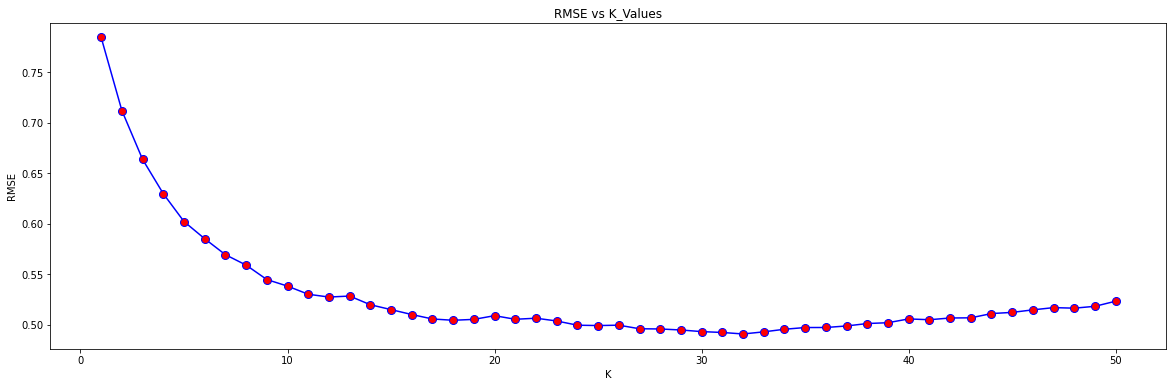

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))

plt.plot(range(1,51),RMSE,color='blue', linestyle='solid', marker='o',markerfacecolor='red', markersize=8)
plt.title('RMSE vs K_Values')
plt.xlabel('K')
plt.ylabel('RMSE')

#Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.5148200808009865
Train data MSE:  0.26503971559593426
Test data MAE:  0.36984419045783046
-------------------------------------------------------------------------------------
Test data RMSE:  0.5233030209190835
Test data MSE:  0.27384605170303883
Test data MAE:  0.4130044706818181


#Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.981608069984401
Test data explained variance regression score: 0.7633069743540919


#R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9814949323373988
Test data R2 score: 0.7625681320055031


#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  5.2626051584282826e-05
Test data MGD:  4.924116578112001e-05
----------------------------------------------------------------------
Train data MPD:  0.0037303812723420027
Test data MPD:  0.0036718055324972067


#Comparision between original forex close price vs predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_forex_rate['Date'],
                       'original_close': close_forex_rate['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'forex rate','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1302, 1)
Test predicted data:  (1302, 1)


#Predicting next 10 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = neighbor.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


#Plotting last 15 days and next predicted 10 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Forex Price','index': 'Days'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#Plotting whole closing forex rate with prediction

In [ ]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(knndf,labels={'value': 'Forex rate','index': 'Days'})
fig.update_layout(title_text='Plotting whole closing forex rate with prediction',
                  plot_bgcolor='white', font_size=20, font_color='black',legend_title_text='Forex')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [ ]:
finaldf = pd.DataFrame({
    'svr':svrdf,
    'rf':rfdf,
    'knn':knndf,

})
finaldf.head()

,svr,rf,knn
0,64.360001,64.360001,64.360001
1,64.165497,64.165497,64.165497
2,64.038300,64.038300,64.038300
3,63.900002,63.900002,63.900002
4,64.230003,64.230003,64.230003


In [ ]:
names = cycle(['SVR', 'RF','KNN'])

fig = px.line(finaldf[1200:], x=finaldf.index[1200:], y=[finaldf['svr'][1200:],finaldf['rf'][1200:], finaldf['knn'][1200:]],
             labels={'x': 'Days','value':'forex close price'})
fig.update_layout(title_text='Final forex rate analysis chart', font_size=20, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()